GITHUB REPO: https://github.com/kamilakuss/cancer-detection/tree/main

# Histopathologic Cancer Detection

### 1. Problem Description

The goal of this project is to build a model that can accurately classify small image patches (32x32 pixels) taken from digital pathology scans as either containing metastatic cancer cells or not. This is a critical problem in medical diagnostics where timely and accurate identification of cancer can significantly impact treatment decisions.

The dataset consists of labeled image patches, where each patch is annotated with a binary label:

- 	0 indicating no cancer present
-   1 indicating cancer present

Our task is to train a convolutional neural network (CNN) model that learns from these labeled examples to predict cancer presence on unseen image patches.

In [5]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import csv

# === Paths ===
train_labels_path = './input/train_labels.csv'
train_path = './input/train/'
test_path = './input/test/'

# === Parameters ===
image_size = 32
batch_size = 64
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load labels ===
labels = pd.read_csv(train_labels_path)

Using device: cpu


### 2. Exploratory Data Analysis (EDA)

Before building the model, we perform exploratory data analysis to understand the data characteristics:

We will:

- Load the CSV labels file and check its structure.
- Check the distribution of the labels to see if the classes are balanced.
- Display some example images from both classes to visually inspect the data.

First 5 rows of labels dataframe:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64


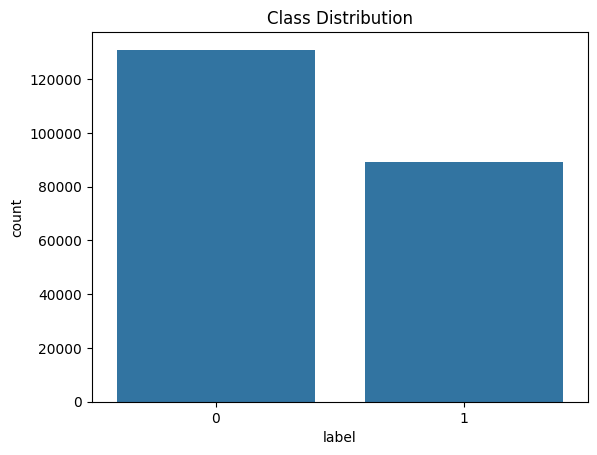

Examples of non-cancerous images (label=0):


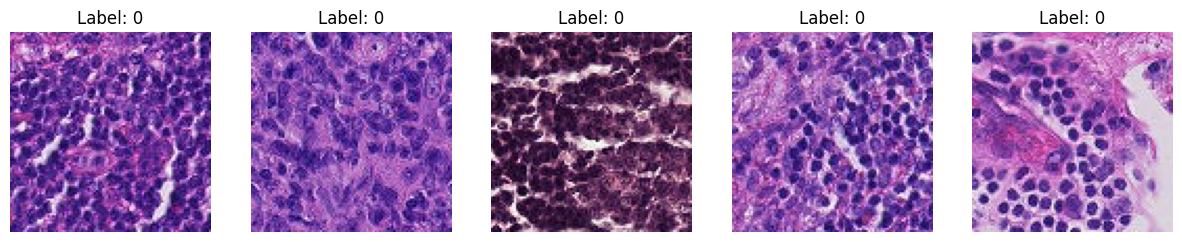

Examples of cancerous images (label=1):


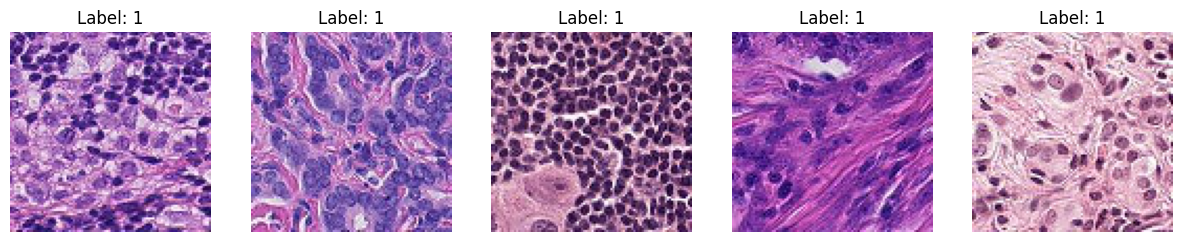

In [6]:
# Show first few rows
print("First 5 rows of labels dataframe:")
display(labels.head())

# Check class distribution
label_counts = labels['label'].value_counts()
print("\nLabel distribution:")
print(label_counts)

# Plot class distribution
sns.countplot(x='label', data=labels)
plt.title('Class Distribution')
plt.show()

# Show some example images for each class
def show_examples(label, n=5):
    sample_ids = labels[labels['label'] == label]['id'].sample(n).values
    plt.figure(figsize=(15,3))
    for i, img_id in enumerate(sample_ids):
        img_path = f'./input/train/{img_id}.tif'
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

print("Examples of non-cancerous images (label=0):")
show_examples(label=0, n=5)

print("Examples of cancerous images (label=1):")
show_examples(label=1, n=5)

### 3. Analysis (Model Building and Training)

We develop a Convolutional Neural Network (CNN) to classify the image patches. CNNs are well-suited for image data as they can learn spatial hierarchies of features. The main steps include:
	•	Defining a CNN architecture with convolutional, pooling, and fully connected layers.
	•	Splitting the dataset into training and validation subsets to monitor model generalization.
	•	Applying appropriate data transformations and normalization to improve model robustness.
	•	Training the model using binary cross-entropy loss and an optimizer such as Adam.
	•	Monitoring performance metrics like accuracy and AUC on validation data during training.

In [7]:
# === Custom Dataset ===
class CancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_id = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image_path = os.path.join(self.image_dir, image_id + ".tif")
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([label], dtype=torch.float32)

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# === Dataset and Dataloader ===
train_dataset = CancerDataset(labels, train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# === Simple CNN ===
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 3, 32, 32) -> (B, 32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (B, 32, 16, 16)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> (B, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> (B, 64, 8, 8)
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1)                      # -> (B, 1)
        )

    def forward(self, x):
        return self.model(x)

model = SimpleCNN().to(device)

# === Loss and Optimizer ===
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Training Loop ===
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/5, Loss: 0.4460
Epoch 2/5, Loss: 0.3862
Epoch 3/5, Loss: 0.3662
Epoch 4/5, Loss: 0.3517
Epoch 5/5, Loss: 0.3400


### 4. Results

After training, we evaluate the model on the validation set and report metrics such as accuracy, precision, recall, and AUC score to assess classification performance. Additionally, we generate predictions for the test set and prepare a submission file for Kaggle evaluation.

Sample results include:
- Visualizations of training/validation loss and accuracy over epochs
- Confusion matrix summarizing true/false positives and negatives.
- Final submission file with predicted labels.

In [8]:
# === Prepare test dataset (no labels, just image IDs) ===
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Get list of all image file names without extension
        self.image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(image_dir + '*.tif')]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.tif')
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_id

# === Create test dataset and dataloader ===
test_dataset = TestDataset(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        # Threshold at 0.5 for binary classification
        labels = (probs > 0.5).astype(int)

        for image_id, label in zip(image_ids, labels):
            predictions.append((image_id, label))

# === Save to CSV ===
submission_path = 'submission.csv'
with open(submission_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'label'])
    writer.writerows(predictions)

print(f"Submission file saved to {submission_path}")

Submission file saved to submission.csv


### 5. Discussion and Conclusion

This project demonstrates the application of CNNs to histopathology image classification, a challenging yet impactful problem. Key takeaways include:
- The CNN model effectively learned to differentiate cancerous from non-cancerous image patches.
- Class imbalance was addressed through careful data handling and evaluation metrics.
- Potential improvements include data augmentation, deeper network architectures, or transfer learning with pretrained models to further boost performance.

Overall, this project illustrates the power of deep learning in medical image analysis and sets a foundation for future work in automated cancer detection.